In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, recall_score
from sklearn.metrics import precision_score
import joblib

def calculate_vpd(temperature, humidity):
    """Calculate Vapor Pressure Deficit (VPD) given temperature (°C) and relative humidity (%)."""
    es = 0.6108 * np.exp((17.27 * temperature) / (temperature + 237.3)) 
    ea = es * (humidity / 100.0)
    vpd = es - ea
    return vpd

In [94]:
# LOAD DATASET

climate_df = pd.read_csv('GreenhouseClimate.csv', low_memory=False)
weather_df = pd.read_csv('Weather.csv', low_memory=False)
grodan_df = pd.read_csv('GrodanSens.csv', low_memory=False)

# Merge on time
merged_df = pd.merge(climate_df, weather_df, on='%time', how='inner')
full_df = pd.merge(merged_df, grodan_df, on='%time', how='inner')
print(f"Hợp nhất thành công! Kích thước: {full_df.shape}")

# Convert time column
full_df['datetime'] = pd.to_datetime(full_df['%time'], unit='D', origin='1899-12-30')
full_df.set_index('datetime', inplace=True)
full_df.drop('%time', axis=1, inplace=True)

Hợp nhất thành công! Kích thước: (47809, 66)


In [95]:
env_features = [
    # Từ GreenhouseClimate
    'Tair', 'Rhair', 'CO2air', 'HumDef', 'PipeGrow', 'PipeLow', 'Tot_PAR',
    # Từ Weather
    'Tout', 'Rhout', 'Iglob', 'Windsp', 'RadSum', 'Rain', 'PARout', 'Pyrgeo', 'AbsHumOut',
    # Từ GrodanSens
    'EC_slab1', 'EC_slab2', 'WC_slab1', 'WC_slab2', 't_slab1', 't_slab2',
    # Cột target
    'Cum_irr'
]
print(f"  - Giữ lại {len(env_features)} cột môi trường và cột target.")
clean_df = full_df[env_features].copy()


  - Giữ lại 23 cột môi trường và cột target.


In [96]:
for col in clean_df.columns:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')
print("  - Chuyển đổi sang kiểu số hoàn tất.")
clean_df.dropna(subset=env_features[:-1], inplace=True) 
print(f"  - Số dòng SAU khi loại bỏ NaN: {len(clean_df)}")

  - Chuyển đổi sang kiểu số hoàn tất.
  - Số dòng SAU khi loại bỏ NaN: 45460


In [97]:
# FEATURE ENGINEERING - for 30 minutes window

# 1. Define Sensor Groups
state_sensors = [
    'Tair', 'Rhair', 'CO2air', 'PipeGrow', 'PipeLow', 
    'WC_slab1', 'WC_slab2', 't_slab1', 'HumDef'
]

# Sensors where the "Total Energy" matters (Accumulate with Sum)
energy_sensors = [
    'Iglob', 'Tot_PAR', 'RadSum', 'PARout'
]

WINDOW_SIZE_30M = 6  # 30 minutes (6 samples)

# 2. Generate Smoothed Aggregates
print("Generating 30-minute aggregates...")

for col in state_sensors:
    # Create _avg version
    if col in clean_df.columns:
        clean_df[f'{col}_30m_avg'] = clean_df[col].rolling(window=WINDOW_SIZE_30M).mean()

for col in energy_sensors:
    # Create _sum version
    if col in clean_df.columns:
        clean_df[f'{col}_30m_sum'] = clean_df[col].rolling(window=WINDOW_SIZE_30M).sum()

# 3. Generate Specific Trends (The "Motion" features)
# We only need trends for the most critical drivers: Heat and Soil Moisture
clean_df['Tair_30m_trend'] = clean_df['Tair'].diff(WINDOW_SIZE_30M)     # Is it heating up?
clean_df['WC_slab1_30m_trend'] = clean_df['WC_slab1'].diff(WINDOW_SIZE_30M) # Is it drying out fast?

# 4. Generate Derived Physics
clean_df['VPD_30m_avg'] = calculate_vpd(clean_df['Tair_30m_avg'], clean_df['Rhair_30m_avg'])

# 5. Interaction Terms (Using Aggregates)
# Heat Load = Avg Temp * Total Sun
clean_df['Heat_Load_30m'] = clean_df['Tair_30m_avg'] * clean_df['Iglob_30m_sum'] 

# 6. Time Features: Dropped

# 7. Drop Raw Instantaneous Columns
cols_to_drop = state_sensors + energy_sensors
clean_df.drop(columns=cols_to_drop, axis=1, inplace=True, errors='ignore')

print(" - Feature Engineering complete.")
print(f" - Raw sensors dropped. Kept {clean_df.shape[1]} features representing 30-min windows.")

# 8. Clean NaN created by rolling window
clean_df.dropna(inplace=True)

Generating 30-minute aggregates...


 - Feature Engineering complete.
 - Raw sensors dropped. Kept 27 features representing 30-min windows.


In [98]:
# XÁC ĐỊNH BIẾN MỤC TIÊU VÀ RESAMPLE (3-HOUR CYCLE)

# 1. Dọn dẹp và nội suy cột Cumulative Irrigation
clean_df['Cum_irr'] = pd.to_numeric(clean_df['Cum_irr'], errors='coerce')
clean_df['Cum_irr'].interpolate(method='time', inplace=True)
clean_df['Cum_irr'].fillna(method='ffill', inplace=True)

# 2. TÍNH TOÁN LƯỢNG NƯỚC THỰC TẾ (5-min interval)
raw_water_diff = clean_df['Cum_irr'].diff()

# Giữ lại giá trị dương, đặt âm thành 0
clean_df['Watering_Amount'] = np.where(raw_water_diff > 0, raw_water_diff, 0)

# Xóa cột cũ không cần thiết
clean_df.drop('Cum_irr', axis=1, inplace=True)
clean_df = clean_df.iloc[1:].copy() 

print("\n--- ĐANG CHUYỂN ĐỔI SANG CHU KỲ 3 GIỜ (RESAMPLING) ---")

# 3. ĐỊNH NGHĨA CÁCH GỘP DỮ LIỆU
# - Target ('Watering_Amount'): Cộng tổng lượng nước trong 3 giờ.
# - Features (Tair, VPD, etc.): Lấy giá trị CUỐI CÙNG (Last) của chu kỳ.
#   (Vì giá trị cuối cùng chứa 'Tair_30m_avg' - tức là trung bình 30p lúc máy thức)

conversion_dict = {
    'Watering_Amount': 'sum'
}

# Tất cả các cột còn lại (features) sẽ dùng 'last'
input_features = [c for c in clean_df.columns if c != 'Watering_Amount']
for col in input_features:
    conversion_dict[col] = 'last'

# 4. THỰC HIỆN RESAMPLE
df_3h = clean_df.resample('3H').agg(conversion_dict)

# Loại bỏ các dòng bị NaN sau khi gộp (nếu có)
df_3h.dropna(inplace=True)

print(f"✅ Đã chuyển đổi xong!")
print(f" - Dữ liệu gốc (5 phút): {clean_df.shape}")
print(f" - Dữ liệu mới (3 giờ):   {df_3h.shape}")

print("\nPhân bố của biến mục tiêu (3-Hour Regression):")
print(df_3h['Watering_Amount'].describe()) 



--- ĐANG CHUYỂN ĐỔI SANG CHU KỲ 3 GIỜ (RESAMPLING) ---
✅ Đã chuyển đổi xong!
 - Dữ liệu gốc (5 phút): (45453, 27)
 - Dữ liệu mới (3 giờ):   (1273, 27)

Phân bố của biến mục tiêu (3-Hour Regression):
count    1273.000000
mean        0.555852
std         0.757841
min         0.000000
25%         0.000000
50%         0.300000
75%         0.800000
max         5.400000
Name: Watering_Amount, dtype: float64


/tmp/ipykernel_283922/753863717.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['Cum_irr'].interpolate(method='time', inplace=True)
/tmp/ipykernel_283922/753863717.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [99]:
print(df_3h.head())
print(f"\nKích thước cuối cùng: {df_3h.shape}")

df_3h.to_csv('processed_greenhouse_data_clean.csv')
print("\nĐã lưu vào file 'processed_greenhouse_data_clean.csv'")

                     Watering_Amount  Tout  Rhout  Windsp  Rain  Pyrgeo  \
datetime                                                                  
2019-12-17 09:00:00              0.0  12.0   80.9     2.7   0.0    -7.0   
2019-12-17 12:00:00              0.0  13.7   75.6     6.8   0.0   -19.0   
2019-12-17 15:00:00              0.0  10.4   95.4     6.4   0.0    -8.0   
2019-12-17 18:00:00              0.0   7.5   99.5     4.7   0.0    -3.0   
2019-12-17 21:00:00              0.0   6.8   97.1     2.1   0.0    -6.0   

                     AbsHumOut  EC_slab1  EC_slab2  t_slab2  ...  \
datetime                                                     ...   
2019-12-17 09:00:00   8.667447       4.5       4.7     18.3  ...   
2019-12-17 12:00:00   9.012995       4.5       4.7     20.4  ...   
2019-12-17 15:00:00   9.227962       4.5       4.7     20.7  ...   
2019-12-17 18:00:00   7.981311       4.6       4.9     18.4  ...   
2019-12-17 21:00:00   7.440940       4.7       4.9     16.4  ...  

In [100]:
print("\n Bắt đầu chuẩn bị dữ liệu huấn luyện (Regression)...")

df_3h = pd.read_csv('processed_greenhouse_data_clean.csv', index_col='datetime', parse_dates=True)
print(f" - Kích thước bộ dữ liệu đã tải: {df_3h.shape}")

y = df_3h['Watering_Amount']
X = df_3h.drop('Watering_Amount', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"  - Kích thước tập Train: {X_train.shape}")
print(f"  - Kích thước tập Test: {X_test.shape}")


 Bắt đầu chuẩn bị dữ liệu huấn luyện (Regression)...
 - Kích thước bộ dữ liệu đã tải: (1273, 27)
  - Kích thước tập Train: (1018, 26)
  - Kích thước tập Test: (255, 26)


In [101]:
# PRUNING IRRELEVANT FEATURE
# These were deemed irrelevant by the LGBM model.
features_to_kill = [
    'Rain', 'AbsHumOut', 'EC_slab1', 'Rhout', 't_slab2', 'Tout', 'Tair_30m_trend', 'EC_slab2', 'VPD_30m_avg', 'Windsp', 'Rhair_30m_avg', 'PipeLow_30m_avg', 't_slab1_30m_avg', 'CO2air_30m_avg', 'Tair_30m_avg', 'Pyrgeo'
]

X_train = X_train.drop(columns=features_to_kill, errors='ignore')
X_test = X_test.drop(columns=features_to_kill, errors='ignore')

print("\n--- Feature Pruning Complete ---")
print(f"🔪 Đã loại bỏ {len(features_to_kill)} features khỏi tập Train/Test.")
print(f"➡️ Số lượng Features Mới: {X_train.shape[1]}")


--- Feature Pruning Complete ---
🔪 Đã loại bỏ 16 features khỏi tập Train/Test.
➡️ Số lượng Features Mới: 10


In [102]:
# PREPARING CLEAN RAW DATA FOR MCU SIMULATION

# 1. Identify Survivors
surviving_features = X_train.columns.tolist()

# 2. Map back to Raw Sensors
raw_sensors_needed = set()
for feat in surviving_features:
    if 'VPD' in feat:
        raw_sensors_needed.add('Tair')
        raw_sensors_needed.add('Rhair')
    elif 'Heat_Load' in feat:
        raw_sensors_needed.add('Tair')
        raw_sensors_needed.add('Iglob')
    elif '_30m' in feat:
        raw_name = feat.split('_30m')[0]
        raw_sensors_needed.add(raw_name)
    elif feat in ['hour', 'dayofweek']:
        continue 
    else:
        raw_sensors_needed.add(feat)

raw_sensors_needed.add('Cum_irr') # Always keep for validation

# 3. Create Simulation DataFrame from FULL_DF
if 'full_df' in globals():
    simulation_df = full_df[list(raw_sensors_needed)].copy()
    
    print(f"Original Row Count: {len(simulation_df)}")

    # 4. Force numberic conversion
    for col in simulation_df.columns:
        simulation_df[col] = pd.to_numeric(simulation_df[col], errors='coerce')
    
    # 5. Drop Rows with ANY missing values
    simulation_df.dropna(inplace=True)
    print(f"Cleaned Row Count:  {len(simulation_df)}")
    
    # 6. Save
    sim_filename = 'mcu_simulation_raw_input.csv'
    simulation_df.to_csv(sim_filename)
    print(f"✅ Saved clean 5-min data to: {sim_filename}")

else:
    print("❌ Error: 'full_df' is missing.")

Original Row Count: 47809
Cleaned Row Count:  45460
✅ Saved clean 5-min data to: mcu_simulation_raw_input.csv


In [103]:
# TRAIN MODEL

lgb_reg = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=100,
    learning_rate=0.025,
    num_leaves=15,
    max_depth=5,
    min_child_samples=10,
    # --------------------------
    random_state=42,
    n_jobs=-1,
    reg_alpha=0.1,
    colsample_bytree=0.8
)

start_time = time.time()
lgb_reg.fit(X_train, y_train)
end_time = time.time()

print(f"\nTinh chỉnh hoàn tất trong {(end_time - start_time):.2f} giây.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 1018, number of used features: 10
[LightGBM] [Info] Start training from score 0.490275

Tinh chỉnh hoàn tất trong 0.07 giây.


In [104]:
# EVALUATE MODEL

print("\n--- Đánh giá mô hình trên tập Test (Tương lai) ---")

# 1. Dự đoán
y_pred = lgb_reg.predict(X_test)

# 2. Ép các giá trị âm về 0 (Mô hình hồi quy đôi khi dự đoán -0.01)
y_pred = np.maximum(y_pred, 0)

# 3. Metrics Hồi quy (Độ chính xác về lượng nước)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE (Sai số bình phương trung bình): {rmse:.4f}")
print(f"📉 MAE (Sai số tuyệt đối trung bình):  {mae:.4f}")
print(f"📊 R2 Score (Độ phù hợp): {r2:.4f}")

# 4. CHECK RECALL (Kiểm tra an toàn)
# Nếu thực tế cần > 0.1 đơn vị nước, mà model dự đoán > 0.1, thì là ĐÚNG.
threshold = 0.1 

y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)

print(f"\n--- Kiểm tra an toàn (Classification Proxy) ---")
print(f"🛡️ RECALL (Độ nhạy - Quan trọng nhất): {recall:.4f}")
print(f"🎯 PRECISION (Độ chính xác khi tưới):  {precision:.4f}")


--- Đánh giá mô hình trên tập Test (Tương lai) ---
📉 RMSE (Sai số bình phương trung bình): 0.5581
📉 MAE (Sai số tuyệt đối trung bình):  0.3664
📊 R2 Score (Độ phù hợp): 0.6289

--- Kiểm tra an toàn (Classification Proxy) ---
🛡️ RECALL (Độ nhạy - Quan trọng nhất): 1.0000
🎯 PRECISION (Độ chính xác khi tưới):  0.7333


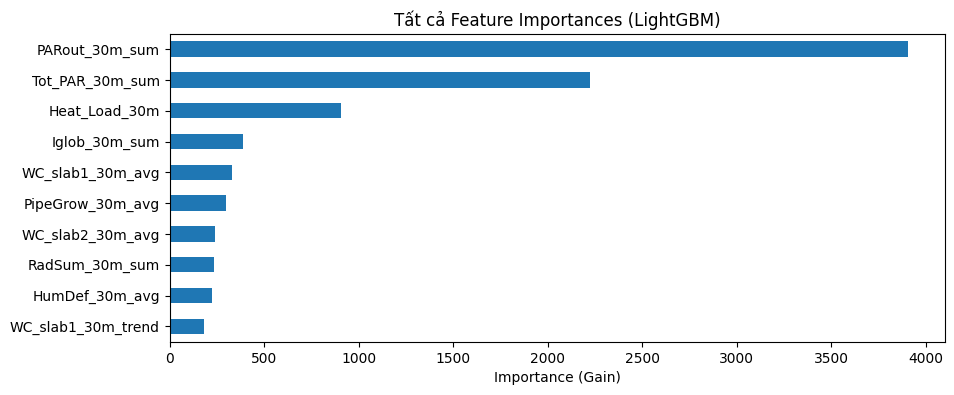

In [105]:
# PLOT IMPORTANT GRAPH

# Lấy feature importance từ booster object và sử dụng 'gain'
feat_importances = pd.Series(lgb_reg.booster_.feature_importance(importance_type='gain'), 
                             index=X_train.columns)

feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10, len(X_train.columns) * 0.4)) 

feat_importances.plot(kind='barh')
plt.gca().invert_yaxis() # Most important first
plt.title("Tất cả Feature Importances (LightGBM)")
plt.xlabel("Importance (Gain)")
plt.show()

In [106]:
# LIST UNIMPORTANT FEATRUE FOR PRUNING

# 1. Get feature names and importance scores
importance = lgb_reg.booster_.feature_importance(importance_type='gain')
features = lgb_reg.booster_.feature_name()

# 2. Create a DataFrame for visualization and filtering
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})

# 3. Filter for unimportant features, sorted
features_to_drop_df = importance_df[importance_df['Importance'] < 100].sort_values(
    by='Importance', ascending=True
)

# 4. Extract the list of feature names
features_to_kill_list = features_to_drop_df['Feature'].tolist()

# 5. Display the results and the ready-to-copy list
print(f"Total features analyzed: {len(features)}")
print("\n--- FEATURES TO DROP ---")
print(features_to_drop_df.to_string(index=False))

print(f"\n💡 Total features recommended for removal: {len(features_to_kill_list)}")

# --- READY TO COPY KILL LIST ---
print("\n✂️ COPY THIS LIST FOR PRUNING: ✂️")
print(str(features_to_kill_list))

Total features analyzed: 10

--- FEATURES TO DROP ---
Empty DataFrame
Columns: [Feature, Importance]
Index: []

💡 Total features recommended for removal: 0

✂️ COPY THIS LIST FOR PRUNING: ✂️
[]


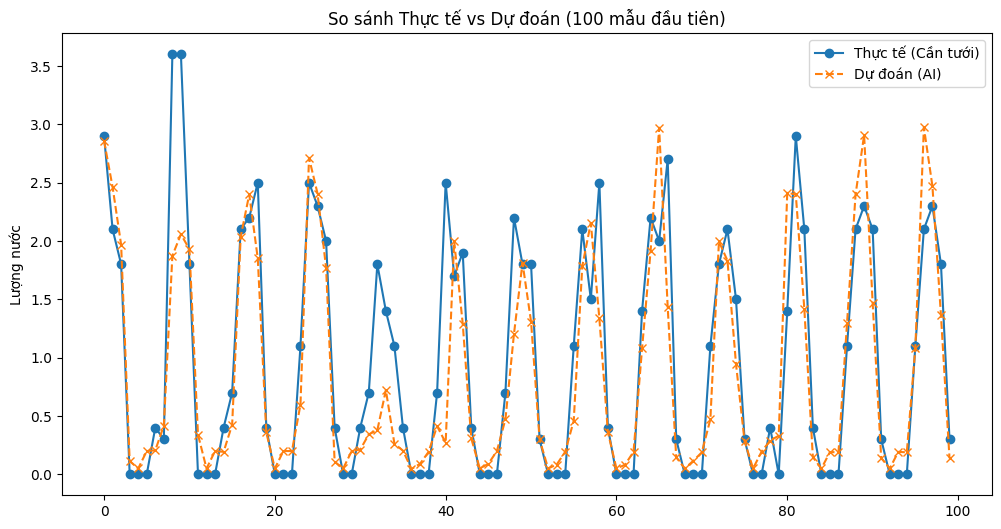

In [107]:
# Compare plot of predicted vs. actual irrigation volumes for the test set.
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Thực tế (Cần tưới)', marker='o')
plt.plot(y_pred[:100], label='Dự đoán (AI)', linestyle='--', marker='x')
plt.title("So sánh Thực tế vs Dự đoán (100 mẫu đầu tiên)")
plt.ylabel("Lượng nước")
plt.legend()
plt.show()

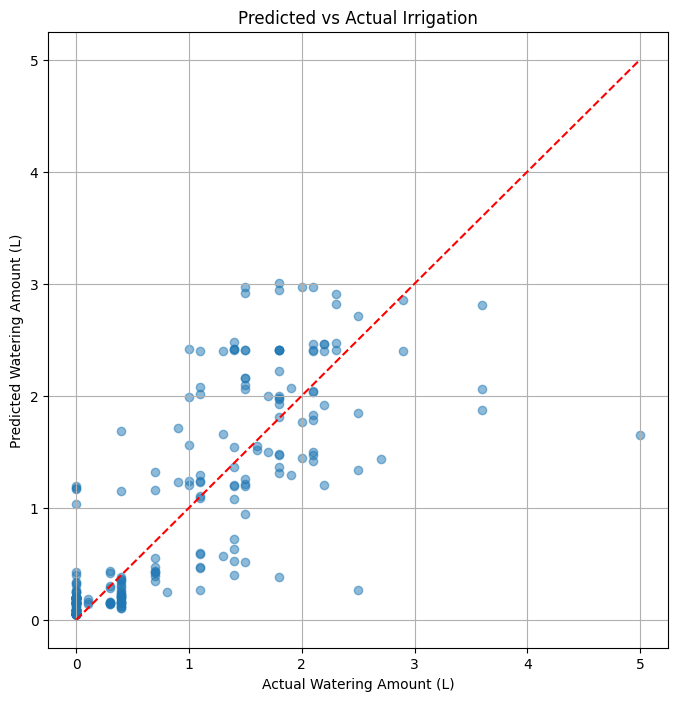

In [108]:
# Scatter plot of predicted vs. actual irrigation volumes for the test set. The red dashed line indicates perfect prediction.

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual Watering Amount (L)")
plt.ylabel("Predicted Watering Amount (L)")
plt.title("Predicted vs Actual Irrigation")
plt.grid(True)
plt.show()


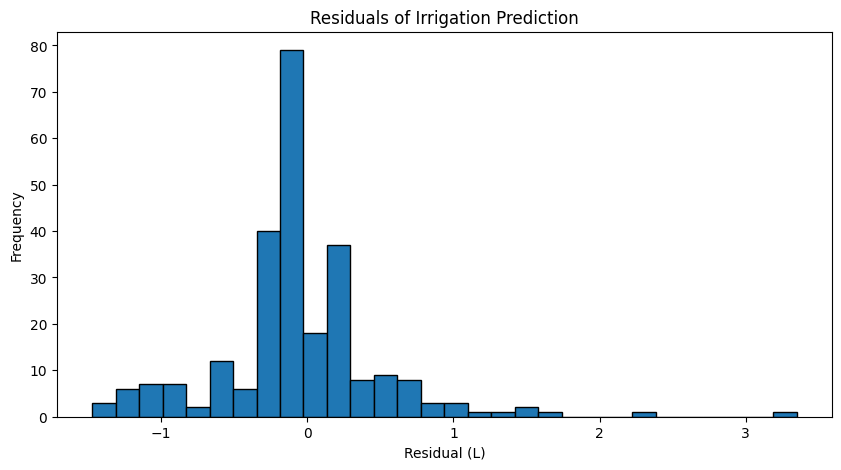

In [109]:
# Histogram of prediction residuals. Most predictions are close to zero error, indicating a good fit.

residuals = y_test - y_pred
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residuals of Irrigation Prediction")
plt.xlabel("Residual (L)")
plt.ylabel("Frequency")
plt.show()


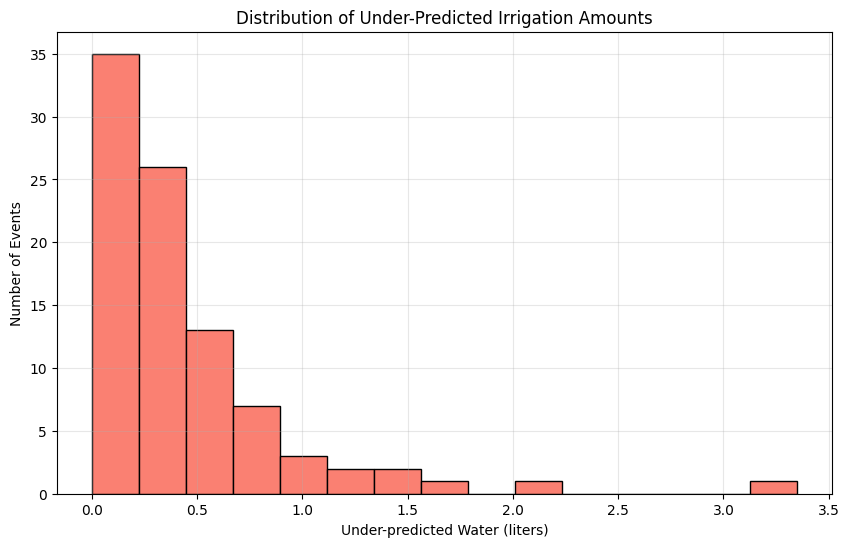

In [110]:
# Distribution of Under-Predicted Irrigation Amounts

under_pred_amounts = y_test[y_pred < y_test] - y_pred[y_pred < y_test]

plt.figure(figsize=(10,6))
plt.hist(under_pred_amounts, bins=15, color='salmon', edgecolor='black')
plt.title("Distribution of Under-Predicted Irrigation Amounts")
plt.xlabel("Under-predicted Water (liters)")
plt.ylabel("Number of Events")
plt.grid(alpha=0.3)
plt.show()


In [111]:
y_test = pd.Series(y_test)  
y_pred = pd.Series(y_pred, index=y_test.index)

# Threshold for extreme events
extreme_threshold = 2.0

# 1. All under-predicted events
under_pred_mask = y_pred < y_test
under_pred_amounts = y_test[under_pred_mask] - y_pred[under_pred_mask]

total_under_pred_percent = under_pred_mask.mean() * 100
print(f"Percentage of under-predicted events: {total_under_pred_percent:.2f}%")
print(f"Average under-predicted per event: {under_pred_amounts.mean():.2f} L")

# 2. Extreme irrigation events
extreme_mask = y_test > extreme_threshold
under_pred_extreme_mask = (y_pred < y_test) & extreme_mask
under_pred_extreme_amounts = y_test[under_pred_extreme_mask] - y_pred[under_pred_extreme_mask]

total_extreme = extreme_mask.sum()
extreme_pct = total_extreme / len(y_test) * 100
under_pred_extreme_pct = under_pred_extreme_mask.sum() / total_extreme * 100

print(f"Percentage of extreme events: {extreme_pct:.2f}%")
print(f"Percentage of extreme events under-predicted: {under_pred_extreme_pct:.2f}%")
print(f"Average under-predicted in extreme events: {under_pred_extreme_amounts.mean():.2f} L")



Percentage of under-predicted events: 35.69%
Average under-predicted per event: 0.44 L
Percentage of extreme events: 12.16%
Percentage of extreme events under-predicted: 61.29%
Average under-predicted in extreme events: 0.90 L


In [112]:
# Average watering amount (Actual vs Predicted)

# Actual average irrigation (3-hour cycle)
actual_avg = y_test.mean()

# Predicted average irrigation (3-hour cycle)
pred_avg = y_pred.mean()

print(f"Average actual watering amount:    {actual_avg:.3f} L per 3-hour cycle")
print(f"Average predicted watering amount: {pred_avg:.3f} L per 3-hour cycle")


Average actual watering amount:    0.818 L per 3-hour cycle
Average predicted watering amount: 0.869 L per 3-hour cycle


In [113]:
import joblib

model_filename = 'irrigation_regressor.joblib' 

joblib.dump(lgb_reg, model_filename)

print(f"✅ Model saved to: {model_filename}")

✅ Model saved to: irrigation_regressor.joblib


In [114]:
# MODEL WEIGHT CHECK
import os

print("\n===== MODEL WEIGHT CHECK =====")

# 1. CHECK STORAGE/RAM WEIGHT (Serialized Size)
temp_file = 'temp_model_check.joblib'
joblib.dump(lgb_reg, temp_file)
size_bytes = os.path.getsize(temp_file)
size_kb = size_bytes / 1024
os.remove(temp_file) # Clean up

print(f"💾 Physical Size: {size_kb:.2f} KB")
print(f"   (This is roughly how much Flash memory it might take)")

# 2. CHECK COMPUTATIONAL WEIGHT (Complexity)
booster = lgb_reg.booster_
num_trees = booster.num_trees()
print(f"🌳 Number of Trees: {num_trees}")

# Estimate C-Code size
# A rough rule of thumb: 1 Tree ~= 1.5 KB of C code source text
est_c_size = num_trees * 1.5
print(f"📝 Estimated C-Code Source Size: ~{est_c_size:.0f} KB")

if size_kb > 1000:
    print("⚠️ WARNING: Model is heavy (>1MB). Might need partition resizing on ESP32.")
else:
    print("✅ GREEN: Model is lightweight and safe for ESP32.")


===== MODEL WEIGHT CHECK =====
💾 Physical Size: 150.47 KB
   (This is roughly how much Flash memory it might take)
🌳 Number of Trees: 100
📝 Estimated C-Code Source Size: ~150 KB
✅ GREEN: Model is lightweight and safe for ESP32.


In [115]:
# FINAL CHECK,  READY FOR EMBEDMENT

print("\n--- Columns in the training set (Pruned) ---")

print(list(X_train.columns))

print(f"\nFinal Input Vector Length: {X_train.shape[1]}")


--- Columns in the training set (Pruned) ---
['PipeGrow_30m_avg', 'WC_slab1_30m_avg', 'WC_slab2_30m_avg', 'HumDef_30m_avg', 'Iglob_30m_sum', 'Tot_PAR_30m_sum', 'RadSum_30m_sum', 'PARout_30m_sum', 'WC_slab1_30m_trend', 'Heat_Load_30m']

Final Input Vector Length: 10
